1. Setup + Spark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Comcast Digital Twin - Model Training") \
    .getOrCreate()

print("✅ Spark session started")

✅ Spark session started


 2. Load Processed Data

In [2]:
df = spark.read.csv("../data/processed_network_data.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- node_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- cpu_usage: double (nullable = true)
 |-- latency: double (nullable = true)
 |-- throughput: double (nullable = true)
 |-- packet_loss: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- error_rate: double (nullable = true)
 |-- failure_label: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- rolling_avg_cpu: double (nullable = true)

+---------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------+----+---------+------------------+
|  node_id|           timestamp|         cpu_usage|           latency|        throughput|        packet_loss|       temperature|         error_rate|failure_label|hour|dayofweek|   rolling_avg_cpu|
+---------+--------------------+------------------+------------------+------------------+------

3. Define Feature Columns & Label

In [3]:
from pyspark.ml.feature import VectorAssembler

# Drop ID and timestamp columns
feature_cols = [col for col in df.columns if col not in ["node_id", "timestamp", "failure_label"]]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df).select("features", "failure_label")

df_vector.show(5)

+--------------------+-------------+
|            features|failure_label|
+--------------------+-------------+
|[50.0248159376537...|            0|
|[28.2699471234741...|            0|
|[29.6994791714308...|            1|
|[27.6650389974085...|            0|
|[30.2006296023390...|            0|
+--------------------+-------------+
only showing top 5 rows



4. Train/Test Split

In [4]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=42)

5. Train Classifier: Random Forest

In [5]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="failure_label", featuresCol="features", numTrees=100)
model = rf.fit(train_data)

print("✅ Model trained!")

✅ Model trained!


6. Evaluate the Model

In [6]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="failure_label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"🔍 ROC-AUC Score: {roc_auc:.4f}")

🔍 ROC-AUC Score: 0.9981


In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(labelCol="failure_label", metricName="accuracy")
accuracy = acc_eval.evaluate(predictions)

print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.9809


Feature Importance

c:\Users\aadit\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


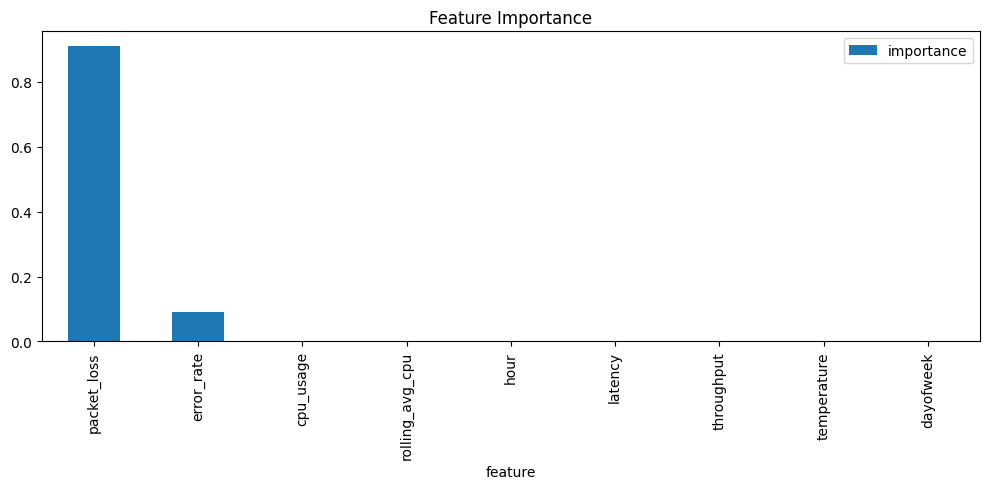

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

features = feature_cols
importances = model.featureImportances.toArray()

imp_df = pd.DataFrame({"feature": features, "importance": importances})
imp_df.sort_values("importance", ascending=False).plot(kind="bar", x="feature", y="importance", figsize=(10, 5), title="Feature Importance")
plt.tight_layout()
plt.show()